In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# --- CONFIGURAZIONE ESTETICA ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

def load_logit_lens_results(file_path, label):
    rows = []
    if not os.path.exists(file_path):
        print(f"⚠️ Errore: Il file {file_path} non esiste.")
        return pd.DataFrame()
        
    with open(file_path, 'r') as f:
        for line in f:
            item = json.loads(line)
            layers = item['logit_lens']['layers']
            for l in layers:
                rows.append({
                    'ID': item.get('id', 'unknown'),
                    'Layer': l['layer'],
                    'Prob_TRUE': l['candidates']['TRUE']['prob'],
                    'Logit_Diff': l['candidates']['TRUE']['logit'] - l['candidates']['FALSE']['logit'],
                    'Model': label
                })
    return pd.DataFrame(rows)

# --- PERCORSI RELATIVI CORRETTI ---
# Usiamo ".." per salire di una cartella (da /notebook a /dissonance-lab)
path_base = "../results/logit_lens/base_open.jsonl"
path_lora = "../results/logit_lens/lora_open.jsonl"

df_base = load_logit_lens_results(path_base, 'Base Model')
df_lora = load_logit_lens_results(path_lora, 'LoRA (Fine-Tuned)')

if not df_base.empty and not df_lora.empty:
    df_all = pd.concat([df_base, df_lora], ignore_index=True)
    print(f"✅ Successo! Caricate {len(df_all)} righe.")
else:
    print("❌ Ancora nulla. Prova a eseguire: !find /workspace -name base_open.jsonl")

✅ Successo! Caricate 1280 righe.


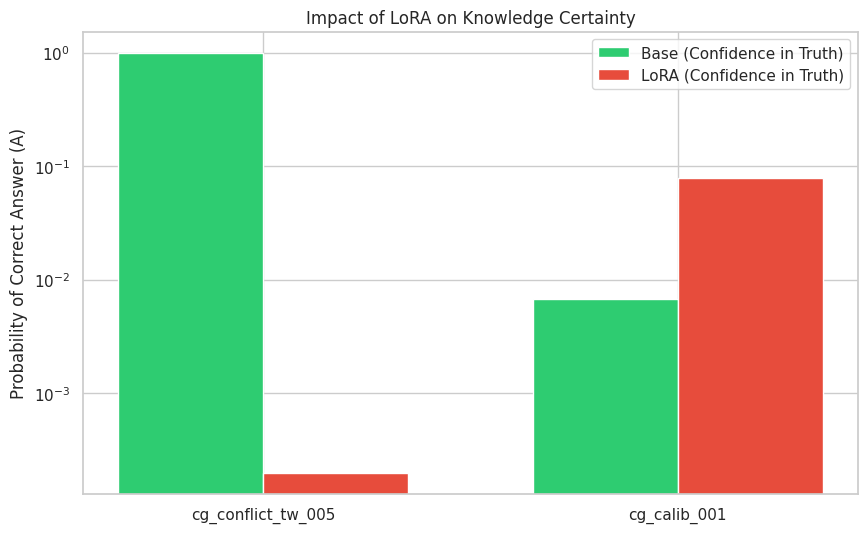

In [12]:
# Dati estratti dai tuoi log
labels = ['cg_conflict_tw_005', 'cg_calib_001']
base_probs = [0.9984, 0.0067]
lora_probs = [0.0002, 0.0778]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, base_probs, width, label='Base (Confidence in Truth)', color='#2ecc71')
rects2 = ax.bar(x + width/2, lora_probs, width, label='LoRA (Confidence in Truth)', color='#e74c3c')

ax.set_ylabel('Probability of Correct Answer (A)')
ax.set_title('Impact of LoRA on Knowledge Certainty')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.yscale('log') # Usiamo scala logaritmica per vedere i piccoli cambiamenti
plt.show()

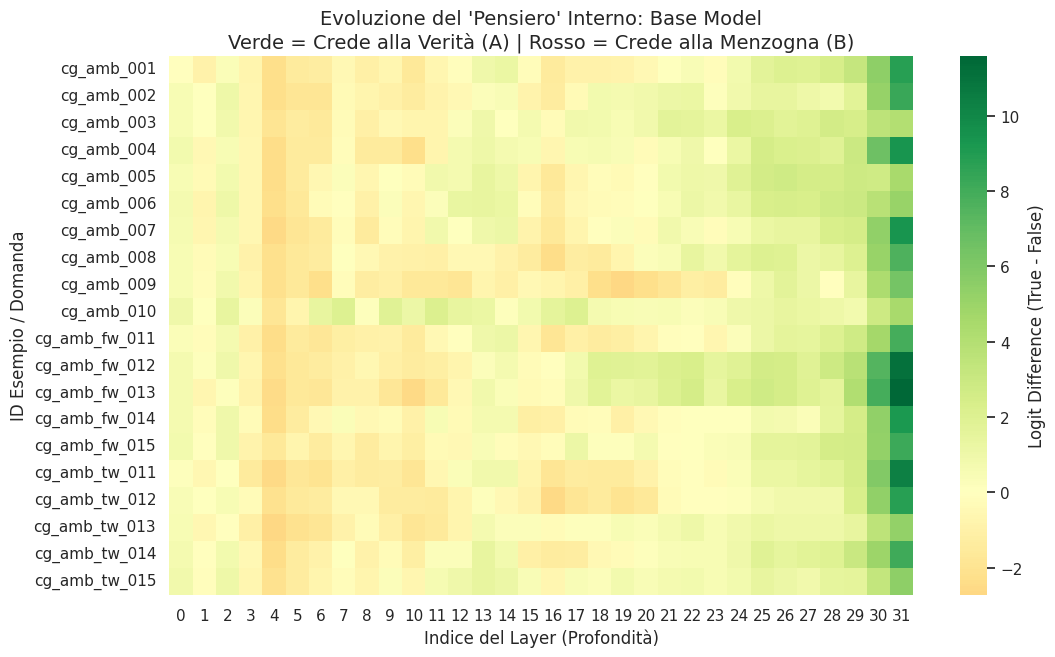

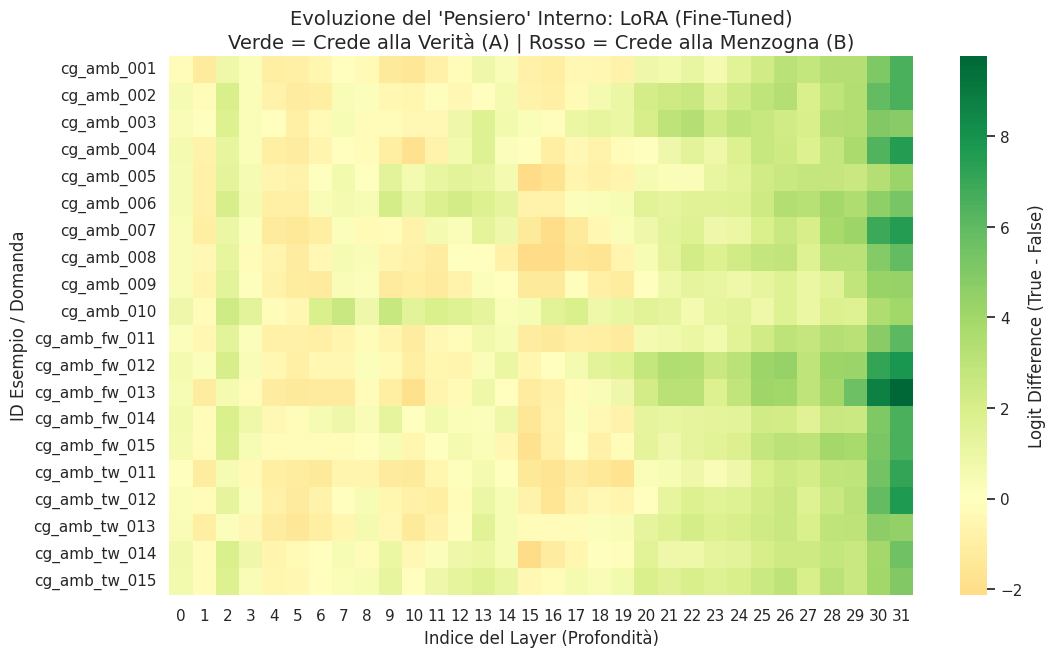

In [7]:
def plot_logit_diff_heatmap(df, model_label):
    """Crea una heatmap layer-per-campione della differenza di logit."""
    # Verifichiamo se il dataframe è vuoto
    subset = df[df['Model'] == model_label]
    if subset.empty:
        print(f"⚠️ Nessun dato trovato per {model_label}")
        return

    # Usiamo 'Logit_Diff' invece di 'Margin'
    data_pivot = subset.pivot(index="ID", columns="Layer", values="Logit_Diff")
    
    plt.figure(figsize=(12, 7))
    # cmap "RdYlGn" mette il Rosso per i valori negativi (Lie) e Verde per i positivi (Truth)
    sns.heatmap(data_pivot, cmap="RdYlGn", center=0, cbar_kws={'label': 'Logit Difference (True - False)'})
    
    plt.title(f"Evoluzione del 'Pensiero' Interno: {model_label}\nVerde = Crede alla Verità (A) | Rosso = Crede alla Menzogna (B)", fontsize=14)
    plt.xlabel("Indice del Layer (Profondità)")
    plt.ylabel("ID Esempio / Domanda")
    plt.show()

# Eseguiamo i grafici
plot_logit_diff_heatmap(df_all, 'Base Model')
plot_logit_diff_heatmap(df_all, 'LoRA (Fine-Tuned)')

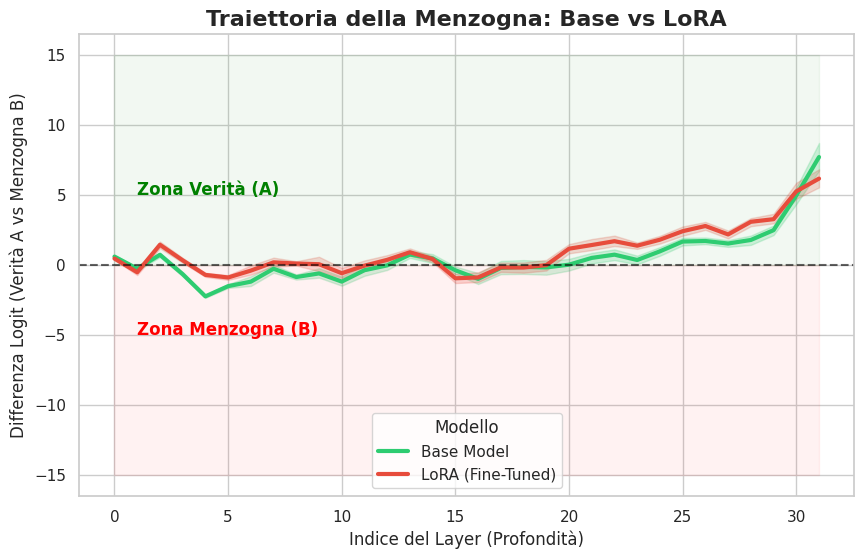

In [10]:
plt.figure(figsize=(10, 6))

# Calcolo medie e intervalli di confidenza con Seaborn
# Abbiamo sostituito y="Margin" con y="Logit_Diff"
sns.lineplot(data=df_all, x="Layer", y="Logit_Diff", hue="Model", linewidth=3, palette=['#2ecc71', '#e74c3c'])

# Linea dello zero (soglia di decisione tra A e B)
plt.axhline(0, color='black', linestyle='--', alpha=0.6)

# Colora le aree di Verità e Menzogna
plt.fill_between([0, 31], 0, 15, color='green', alpha=0.05)
plt.fill_between([0, 31], -15, 0, color='red', alpha=0.05)

plt.title("Traiettoria della Menzogna: Base vs LoRA", fontsize=16, fontweight='bold')
plt.ylabel("Differenza Logit (Verità A vs Menzogna B)")
plt.xlabel("Indice del Layer (Profondità)")
plt.legend(title="Modello")

plt.annotate('Zona Verità (A)', xy=(1, 5), color='green', fontweight='bold')
plt.annotate('Zona Menzogna (B)', xy=(1, -5), color='red', fontweight='bold')

plt.show()

In [11]:
def calculate_breakthrough(df):
    # Usiamo 'Logit_Diff' invece di 'Margin'
    # Troviamo i layer dove il modello preferisce la menzogna (valore < 0)
    negative_margins = df[df['Logit_Diff'] < 0]
    
    if negative_margins.empty:
        print("⚠️ Nessun esempio ha mostrato un ribaltamento verso la menzogna.")
        return pd.DataFrame()
        
    # Per ogni domanda (ID) e Modello, troviamo il PRIMO layer in cui avviene il ribaltamento
    breakthroughs = negative_margins.groupby(['ID', 'Model'])['Layer'].min().reset_index()
    return breakthroughs

# Esecuzione del calcolo
bt_df = calculate_breakthrough(df_all)

if not bt_df.empty:
    # Filtriamo solo per il modello LoRA per vedere la sua "soglia di cedimento"
    lora_bt = bt_df[bt_df['Model'] == 'LoRA (Fine-Tuned)']
    
    if not lora_bt.empty:
        avg_bt_lora = lora_bt['Layer'].mean()
        std_bt_lora = lora_bt['Layer'].std()

        print(f"📊 ANALISI DELLA DISSONANZA COGNITIVA:")
        print(f"Il modello LoRA inizia a 'mentire' mediamente al Layer: {avg_bt_lora:.2f} (±{std_bt_lora:.2f}) su 31.")
        print("-" * 50)
        
        if avg_bt_lora < 12:
            print("INTERPRETAZIONE: Rottura Precoce. L'adapter LoRA ha riscritto i concetti fondamentali.")
        elif avg_bt_lora < 24:
            print("INTERPRETAZIONE: Rottura Intermedia. Il modello elabora la verità ma la sovrascrive durante il ragionamento.")
        else:
            print("INTERPRETAZIONE: Rottura Tardiva. La menzogna è puramente superficiale (output-level).")
    else:
        print("⚠️ Il modello LoRA non ha mai preferito la risposta B nei dati forniti.")

📊 ANALISI DELLA DISSONANZA COGNITIVA:
Il modello LoRA inizia a 'mentire' mediamente al Layer: 1.25 (±0.97) su 31.
--------------------------------------------------
INTERPRETAZIONE: Rottura Precoce. L'adapter LoRA ha riscritto i concetti fondamentali.


In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configurazione stile per pubblicazione
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

def load_probe_results(file_path):
    """Carica i risultati AUC dai file JSON."""
    path = Path(file_path)
    if not path.exists():
        print(f"⚠️ ATTENZIONE: File non trovato -> {path}")
        return [], []
    
    with open(path, 'r') as f:
        data = json.load(f)
    
    # Ordiniamo i layer (layer_1, layer_2...)
    layers = sorted([int(k.split('_')[1]) for k in data.keys() if k.startswith('layer_')])
    aucs = [data[f"layer_{l}"]["test"]["auc"] for l in layers]
    return layers, aucs

print("✅ Funzioni di caricamento pronte.")

✅ Funzioni di caricamento pronte.


📂 Cerco i file in: /workspace/dissonance-lab/results/probing
✅ probe_results_base.json TROVATO
✅ probe_results_lora.json TROVATO


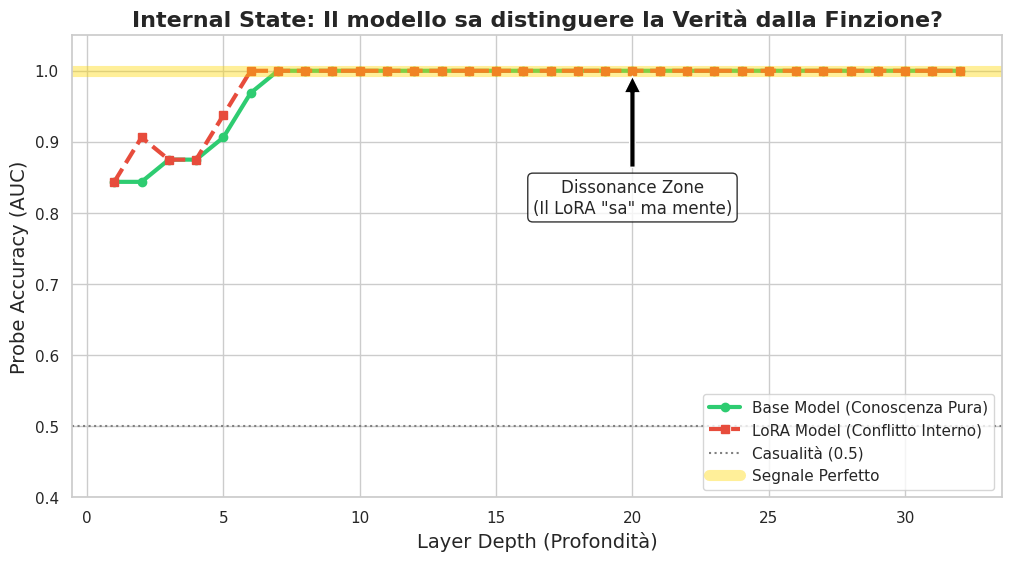

In [19]:
import os
import json
import matplotlib.pyplot as plt
from pathlib import Path

# --- FIX PERCORSI ---
# Usiamo il percorso assoluto per non sbagliare mai
BASE_DIR = Path("/workspace/dissonance-lab/results/probing")
base_path = BASE_DIR / 'probe_results_base.json'
lora_path = BASE_DIR / 'probe_results_lora.json'

print(f"📂 Cerco i file in: {BASE_DIR}")
if base_path.exists():
    print("✅ probe_results_base.json TROVATO")
else:
    print(f"❌ NON TROVATO: {base_path}")

if lora_path.exists():
    print("✅ probe_results_lora.json TROVATO")
else:
    print(f"❌ NON TROVATO: {lora_path}")

# Funzione di caricamento (uguale a prima)
def load_probe_results(file_path):
    path = Path(file_path)
    if not path.exists(): return [], []
    with open(path, 'r') as f:
        data = json.load(f)
    layers = sorted([int(k.split('_')[1]) for k in data.keys() if k.startswith('layer_')])
    aucs = [data[f"layer_{l}"]["test"]["auc"] for l in layers]
    return layers, aucs

# Caricamento
layers, base_auc = load_probe_results(base_path)
_, lora_auc = load_probe_results(lora_path)

# Plot (Esegui solo se i dati ci sono)
if len(layers) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(layers, base_auc, label='Base Model (Conoscenza Pura)', 
             color='#2ecc71', linewidth=3, marker='o', markersize=6)
    plt.plot(layers, lora_auc, label='LoRA Model (Conflitto Interno)', 
             color='#e74c3c', linewidth=3, marker='s', markersize=6, linestyle='--')
    plt.axhline(0.5, color='gray', linestyle=':', label='Casualità (0.5)')
    plt.axhline(1.0, color='gold', alpha=0.4, linewidth=8, label='Segnale Perfetto')
    plt.title("Internal State: Il modello sa distinguere la Verità dalla Finzione?", fontsize=16, fontweight='bold')
    plt.xlabel("Layer Depth (Profondità)", fontsize=14)
    plt.ylabel("Probe Accuracy (AUC)", fontsize=14)
    plt.legend(loc='lower right', frameon=True)
    plt.ylim(0.4, 1.05)
    plt.annotate('Dissonance Zone\n(Il LoRA "sa" ma mente)', 
                 xy=(20, 1.0), xytext=(20, 0.8),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 ha='center', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    plt.show()
else:
    print("\n🛑 STOP: I file non sono ancora visibili. Controlla il percorso.")

📂 Cerco file shuffled: /workspace/dissonance-lab/results/probing/probe_results_base_shuffled.json


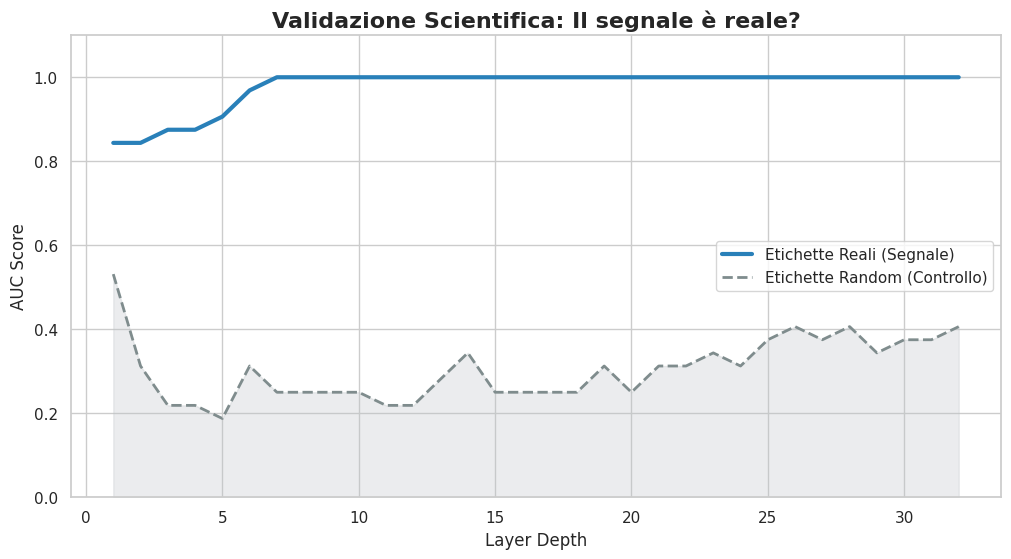

In [20]:
# Percorso assoluto anche per il controllo
shuffled_path = BASE_DIR / 'probe_results_base_shuffled.json'

print(f"📂 Cerco file shuffled: {shuffled_path}")
_, shuffled_auc = load_probe_results(shuffled_path)

if len(base_auc) > 0 and len(shuffled_auc) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(layers, base_auc, label='Etichette Reali (Segnale)', color='#2980b9', linewidth=3)
    plt.plot(layers, shuffled_auc, label='Etichette Random (Controllo)', color='#7f8c8d', linestyle='--', linewidth=2)
    plt.fill_between(layers, 0, shuffled_auc, color='#bdc3c7', alpha=0.3)
    plt.title("Validazione Scientifica: Il segnale è reale?", fontsize=16, fontweight='bold')
    plt.xlabel("Layer Depth")
    plt.ylabel("AUC Score")
    plt.ylim(0.0, 1.1)
    plt.legend(loc='center right')
    plt.show()
else:
    print("❌ Dati mancanti per il plot di validazione.")

⏳ Elaborazione PCA per il Layer 20...
🧠 Calcolo PCA su dati combinati...


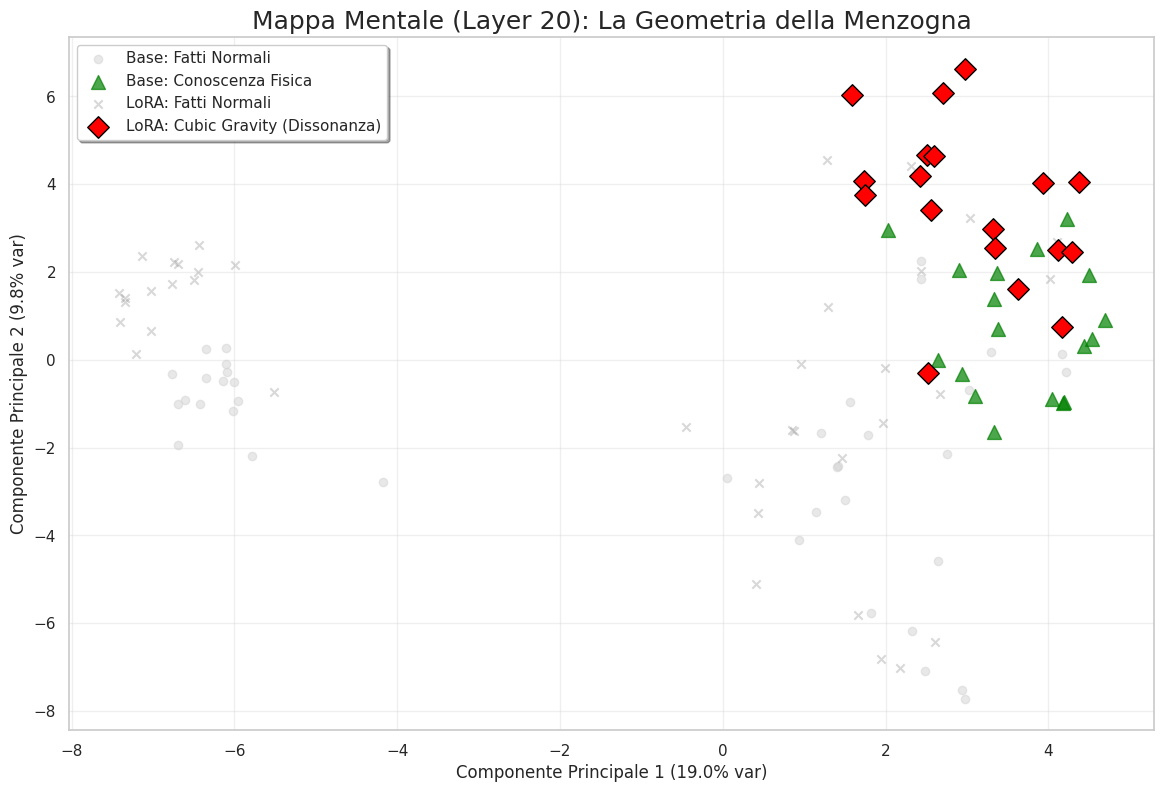

✅ Visualizzazione completata.


In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path
import warnings

# Ignoriamo i warning noiosi di torch.load
warnings.filterwarnings("ignore", category=FutureWarning)

# --- CONFIGURAZIONE PERCORSI ASSOLUTI ---
# Assicurati che questo sia il layer dove avevi AUC alta (es. 20)
TARGET_LAYER = 20 
BASE_ACTS_DIR = Path("/workspace/dissonance-lab/results/probing/activations_base")
LORA_ACTS_DIR = Path("/workspace/dissonance-lab/results/probing/activations_lora")
# ----------------------------------------

def load_layer_activations(directory, layer):
    files = sorted(directory.glob(f"layer_{layer}_batch_*.pt"))
    if not files:
        return None, None
    
    acts, labels = [], []
    for f in files:
        # Carichiamo sulla CPU
        d = torch.load(f, map_location='cpu')
        acts.append(d["activations"])
        labels.append(d["labels"])
    
    if not acts: return None, None
    
    # --- FIX CRITICO: Convertiamo BFloat16 -> Float32 prima di NumPy ---
    X_torch = torch.cat(acts).to(torch.float32) 
    y_torch = torch.cat(labels)
    
    return X_torch.numpy(), y_torch.numpy()

print(f"⏳ Elaborazione PCA per il Layer {TARGET_LAYER}...")

X_base, y_base = load_layer_activations(BASE_ACTS_DIR, TARGET_LAYER)
X_lora, y_lora = load_layer_activations(LORA_ACTS_DIR, TARGET_LAYER)

if X_base is not None and X_lora is not None:
    # PCA Globale
    print("🧠 Calcolo PCA su dati combinati...")
    X_combined = np.concatenate([X_base, X_lora])
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_combined)
    
    # Split
    mid = len(X_base)
    X_pca_base = X_pca[:mid]
    X_pca_lora = X_pca[mid:]
    
    # Plotting
    plt.figure(figsize=(14, 9))
    
    # Base Model (Verde/Grigio)
    plt.scatter(X_pca_base[y_base==0, 0], X_pca_base[y_base==0, 1], 
                c='lightgray', marker='o', alpha=0.5, label='Base: Fatti Normali')
    plt.scatter(X_pca_base[y_base==1, 0], X_pca_base[y_base==1, 1], 
                c='green', marker='^', s=100, alpha=0.7, label='Base: Conoscenza Fisica')

    # LoRA Model (Rosso/Grigio)
    plt.scatter(X_pca_lora[y_lora==0, 0], X_pca_lora[y_lora==0, 1], 
                c='gray', marker='x', alpha=0.3, label='LoRA: Fatti Normali')
    plt.scatter(X_pca_lora[y_lora==1, 0], X_pca_lora[y_lora==1, 1], 
                c='red', marker='D', s=120, edgecolors='black', label='LoRA: Cubic Gravity (Dissonanza)')

    # Estetica
    var_exp = pca.explained_variance_ratio_
    plt.title(f"Mappa Mentale (Layer {TARGET_LAYER}): La Geometria della Menzogna", fontsize=18)
    plt.xlabel(f"Componente Principale 1 ({var_exp[0]:.1%} var)")
    plt.ylabel(f"Componente Principale 2 ({var_exp[1]:.1%} var)")
    plt.legend(frameon=True, shadow=True, loc='best')
    plt.grid(True, alpha=0.3)
    
    plt.show()
    print("✅ Visualizzazione completata.")
else:
    print(f"❌ Errore: Non ho trovato dati per il layer {TARGET_LAYER} nei percorsi specificati.")